<a href="https://colab.research.google.com/github/Kynantio/MachineLearning/blob/main/Jobsheet_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jobsheet 10 Machine Learning
### Kynantio Candra Abrari
### 2141720206 / 3A / 16

# Praktikum 1

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)

# Build your input pipeline
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
for example in ds.take(1):
  image, label = example["image"], example["label"]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This movie rivals "Plan 9" as one of the dumbest movie ever made. Always be concerned when the same person is the:<br /><br />1. Star 2. Director 3. Producer 4. Writer 5. Stuntman, and 6. Editor. Unfortunately, Justin Kreinbrink did all 6 jobs! IMDb shows that he and his father were western \'stunt men\'. So maybe that was the problem. <br /><br />Here\'s just ONE example from the film: in the film the sheriff has to take a witness to another town for protection. Of course, the bad guys find out and are waiting for them. But, what happens? The good guys are riding along and a shot rings out and hits a tree near them. When the camera shows us the bad guys they\'re all just sitting on a log, chatting. What\'s wrong with this picture!<br /><br />I could go on. Perhaps this film was meant as a comedy. If so, it didn\'t do that well either.'
 b"I can't believe I wasted my time with this movie. I couldn't even call it a movie. It was so bad with nothing to recommend it. <br /><br 

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 11,  18,   1, ...,   0,   0,   0],
       [ 10, 175, 256, ...,   0,   0,   0],
       [ 11,   1, 111, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This movie rivals "Plan 9" as one of the dumbest movie ever made. Always be concerned when the same person is the:<br /><br />1. Star 2. Director 3. Producer 4. Writer 5. Stuntman, and 6. Editor. Unfortunately, Justin Kreinbrink did all 6 jobs! IMDb shows that he and his father were western \'stunt men\'. So maybe that was the problem. <br /><br />Here\'s just ONE example from the film: in the film the sheriff has to take a witness to another town for protection. Of course, the bad guys find out and are waiting for them. But, what happens? The good guys are riding along and a shot rings out and hits a tree near them. When the camera shows us the bad guys they\'re all just sitting on a log, chatting. What\'s wrong with this picture!<br /><br />I could go on. Perhaps this film was meant as a comedy. If so, it didn\'t do that well either.'
Round-trip:  this movie [UNK] [UNK] [UNK] as one of the [UNK] movie ever made always be [UNK] when the same person is [UNK] br 1 star 2 di

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.00418821]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 111ms/step
[0.00418821]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 108ms/step - loss: 0.6335 - accuracy: 0.5882 - val_loss: 0.4754 - val_accuracy: 0.7943
Epoch 2/10
391/391 [==============================] - 28s 70ms/step - loss: 0.4068 - accuracy: 0.8131 - val_loss: 0.3769 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3426 - accuracy: 0.8486 - val_loss: 0.3426 - val_accuracy: 0.8526
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3235 - accuracy: 0.8602 - val_loss: 0.3627 - val_accuracy: 0.8188
Epoch 5/10
391/391 [==============================] - 27s 67ms/step - loss: 0.3180 - accuracy: 0.8627 - val_loss: 0.3266 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3067 - accuracy: 0.8672 - val_loss: 0.3238 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3045 - accuracy: 0.8693 - val_loss: 0.3228 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 32ms/step - loss: 0.3257 - accuracy: 0.8437
Test Loss: 0.3257487118244171
Test Accuracy: 0.8436800241470337


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6502959132194519)

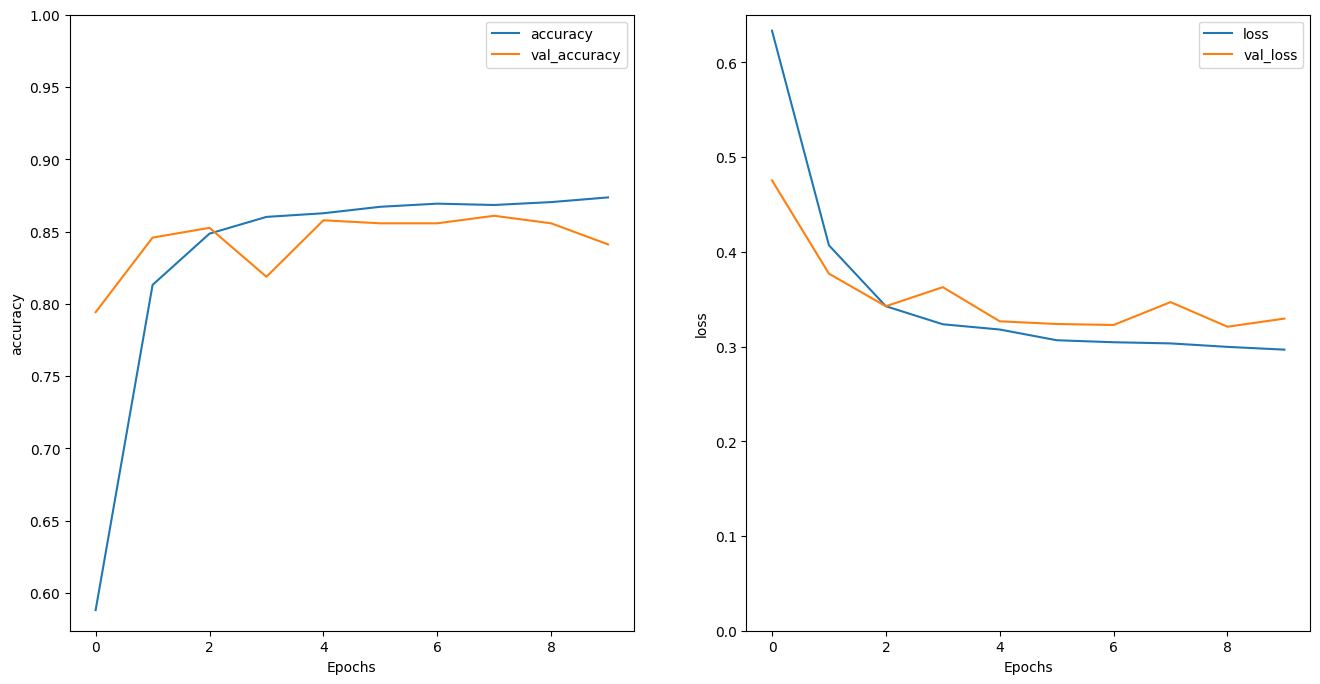

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [ ]:
model = tf.keras.Sequential([
   encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                validation_data=test_dataset,
                validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 159ms/step - loss: 0.6713 - accuracy: 0.5556 - val_loss: 0.6165 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 49s 125ms/step - loss: 0.4695 - accuracy: 0.7638 - val_loss: 0.3953 - val_accuracy: 0.8281
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3755 - accuracy: 0.8380 - val_loss: 0.3579 - val_accuracy: 0.8422
Epoch 4/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3361 - accuracy: 0.8558 - val_loss: 0.3382 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3195 - accuracy: 0.8639 - val_loss: 0.3264 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3109 - accuracy: 0.8673 - val_loss: 0.3206 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3059 - accuracy: 0.8684 - val_loss: 0.3198 - val_ac

# Praktikum 2

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
import tensorflow as tf

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [31]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [32]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [34]:
import tensorflow as tf

example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars


<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [36]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab),mask_token=None)

In [38]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [39]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [40]:
chars = chars_from_ids(ids)
chars


<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [41]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [42]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [43]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [44]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [45]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [46]:
seq_length = 100

In [47]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [48]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [49]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [50]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [51]:
dataset = sequences.map(split_input_target)

In [52]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [53]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [54]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [55]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [56]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [57]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [58]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
sampled_indices = tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [60]:
sampled_indices

array([17, 33, 36, 58, 42, 37, 21, 49, 49,  9, 55,  9, 24,  0, 47, 57, 55,
       60, 56,  4, 38, 59, 61,  2, 49, 62, 63, 43, 39, 48, 52, 14, 16, 18,
        8, 10, 17, 29,  6, 13, 29, 62, 54, 13, 34, 40,  7, 41, 50,  9, 13,
       24, 31, 56, 23, 34, 64, 21, 44, 34,  3, 12,  9, 30, 11, 40, 47, 14,
        8, 45, 58, 11, 47, 34, 64, 48, 54, 48,  3, 18,  9, 37,  0, 64, 25,
       52, 26, 21, 25, 19, 54, 33,  7, 16, 25, 13, 54, 52,  4, 17])

In [61]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ddenly will have\nThe truth of this appear. Prepare you, lords;\nSummon a session, that we may arraign'

Next Char Predictions:
 b"DTWscXHjj.p.K[UNK]hrpuq$Ytv jwxdZimACE-3DP'?Pwo?Ua,bk.?KRqJUyHeU!;.Q:ahA-fs:hUyioi!E.X[UNK]yLmMHLFoT,CL?om$D"


In [62]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [63]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1904936, shape=(), dtype=float32)


In [64]:
tf.exp(example_batch_mean_loss).numpy()

66.05539

In [65]:
model.compile(optimizer='adam', loss=loss)

In [66]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [67]:
EPOCHS = 20

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 60ms/step - loss: 2.7157
Epoch 2/20
172/172 [==============================] - 13s 56ms/step - loss: 1.9836
Epoch 3/20
172/172 [==============================] - 13s 57ms/step - loss: 1.7125
Epoch 4/20
172/172 [==============================] - 12s 57ms/step - loss: 1.5531
Epoch 5/20
172/172 [==============================] - 12s 58ms/step - loss: 1.4543
Epoch 6/20
172/172 [==============================] - 13s 59ms/step - loss: 1.3859
Epoch 7/20
172/172 [==============================] - 13s 60ms/step - loss: 1.3341
Epoch 8/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2883
Epoch 9/20
172/172 [==============================] - 13s 61ms/step - loss: 1.2480
Epoch 10/20
172/172 [==============================] - 14s 62ms/step - loss: 1.2087
Epoch 11/20
172/172 [==============================] - 14s 62ms/step - loss: 1.1692
Epoch 12/20
172/172 [==============================] - 14s 61ms/step - loss: 1.1288
E

In [68]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [69]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [70]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The souls of mine own beatted companymants.

BARNARDONE:
Brother, sir.

VIRGILIA:
Then should, and I follow you;
Even of the minist neck, whose lasts
Of what is little fought and night: here is my pains,
To-day to love, hear me parcels livers;
Apport Still, the flowers can that True; which to hinder
Were it keens of tears and souls,
Like proceddess; or else a foot
Upon my soul is not a palacces for a little,
And more and foul weather with your clothe: hark you
You sit by what she middes of her
come with Margaret: thy wisdom way,
Hen let in familiar draws inclined,--
Let me see thy happiness; but my hands,
Yet west thou slaughter there; it is for hid: I should fair curse
To meet again, and stand with vow.

SICINIUS:
Why do you ne'er hear from her,
Doth her accent of it?

MENENIUS:
And now, good Catesby, he did spend a pawd
of what it dangers; why then, who, I say!
Go, county thou shades of he?

GLOUCESTER:
He is a good night!

AUTOLYCUS:
I hear that idle with holy song, and we he

In [71]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nI hope here comes a virture.\nThis must be say remember'd. I hear thom my son.\nShould account his son is either.\n\nMARIANA:\nYou are welcome home! why came you?--\n'Twould twenty Ruchard makes a gentle, and\nmy standing gesperately. And for Corioli,\nTo your mistress, partly die preserves;\nFor, I hare even then will I.\n\nCLARENCE:\nWhat was Marcius?\nMy comfort is that know this dismon were well desert;\nWhich, of my child, weeping, old laugh in: I saw him\nhe is: between within my hence in sad and the\nAntiatest. Thou execution, when\nfalse for your silence, he is with care?\n\nPOMPEY:\nSir, if it yet hence!\n\nYORK:\nI know not what; what's leant?\n\nFirst Gentleman:\nHear me, my lord, shall Warwick of Petruchio,\nThat he hath been usible things: swearing of!\n\nFRIAR PETER:\nCome hither. Meecy,\nFor in'tis Christian grossmation-wast:\nSome hangman, drunk as disarved folly; even\nTo stretch it reckol'd. And, what dost thou my weary!'\nMy noble voices to me n

In [72]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [73]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Two moves me mine. Fare you well.

BUSON:
Here's angel, for all those troth-bud innocent,
And rice 


# Tugas

In [75]:
class CustomTraining(MyModel):
    @tf.function
    def train_step(self, inputs):
        inputs, labels = inputs
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.loss(labels, predictions)
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return {'loss': loss}


In [77]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)


In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)


In [80]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 18s 67ms/step - loss: 2.7367


In [82]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_" * 80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))


Epoch 1 Batch 0 Loss 2.1887
Epoch 1 Batch 50 Loss 2.0532
Epoch 1 Batch 100 Loss 1.9364
Epoch 1 Batch 150 Loss 1.8952

Epoch 1 Loss: 2.0041
Time taken for 1 epoch 14.98 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8813
Epoch 2 Batch 50 Loss 1.7120
Epoch 2 Batch 100 Loss 1.7023
Epoch 2 Batch 150 Loss 1.6465

Epoch 2 Loss: 1.7270
Time taken for 1 epoch 11.15 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6244
Epoch 3 Batch 50 Loss 1.5825
Epoch 3 Batch 100 Loss 1.5492
Epoch 3 Batch 150 Loss 1.5056

Epoch 3 Loss: 1.5627
Time taken for 1 epoch 11.83 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4672
Epoch 4 Batch 50 Loss 1.4821
Epoch 4 Batch 100 Loss 1.4681
Epoch 4 Batch 150 Loss 1.4808

Epoch 4 Loss: 1.4615
Time taken for 1 epoch 12.82 sec
_____________________________________________________________________